# Band-Limited Angular Spectrum Method for Numerical Simulation of Free-Space Propagation in Far and Near Fields

In [160]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

In [161]:
# freq = np.fft.fftfreq(1024, 1)
# print(freq)
# freq = np.fft.fftshift(freq)
# print(freq)

In [162]:
# freq = np.fft.fftfreq(1024, 2)
# print(freq)

In [163]:
def AS(wave_length=1, n_S=50, band_limit=-1):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq_square = freq**2
    freq_squre_max = np.full(N, 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = np.where(mask, w_square_0, 0)

    # the transfer function
    H_FR = np.empty(N, dtype=complex)
    H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
    # H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

    # generate the source plain spectrum
    g_0 = np.zeros(N)
    g_0[int(N / 4) : int(N / 4 * 3)] = np.ones(int(N / 2))
    # g_0[int(N / 4) : int(N / 4 * 3)] = abs(
    #     np.cos(np.linspace(-2 * math.pi, 2 * math.pi, int(N / 2)))
    # )

    G_0 = np.fft.fft(g_0)

    # the dest plain spectrum
    G_z = G_0 * H_FR

    if band_limit == -1:
        pass
    else:
        # limit the bandwidth
        G_z = np.fft.fftshift(G_z)
        f = band_limit
        G_z[0 : 512 + 1 - f] = np.zeros(513 - f)
        G_z[512 + f : 1024] = np.zeros(512 - f)
        G_z = np.fft.ifftshift(G_z)

    # the dest plain
    g_z = abs(np.fft.ifft(G_z))

    return G_z, g_z

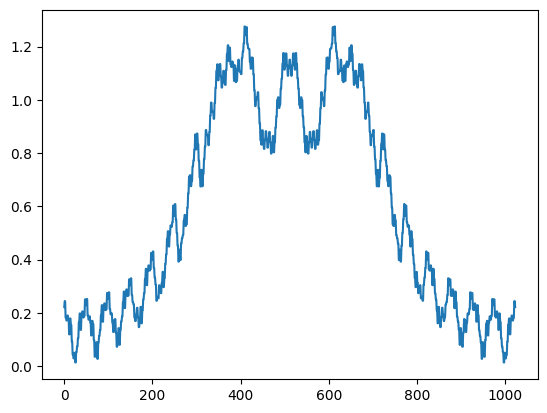

In [164]:
G_z_AS, g_z_AS = AS()
plt.plot(g_z_AS)
plt.show()

In [165]:
from numba import njit


@njit(parallel=True)
def numerical_integration(wave_length=1, n_S=50):
    wave_length = wave_length  # the length of the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    # real = np.zeros(1024)
    # imag = np.zeros(1024)
    inte_result = np.zeros(1024)

    N = 4000

    g_src = np.zeros(N)
    g_src[int(N / 4) : int(N / 4 * 3)] = np.ones(int(N / 2))

    y_real = np.zeros(N)
    y_imag = np.zeros(N)
    x = np.zeros(N)

    d_x = S / N
    for k in range(0, N):
        x[k] = d_x * k

    d_x_dest = 2 * wave_length

    for x_dest_n in range(0, 1024):
        for k in range(0, N):
            r = math.sqrt(z**2 + (x_dest_n * d_x_dest - x[k]) ** 2)
            exp = cmath.exp(2j * math.pi * r / wave_length)
            # print(x_dest_n * d_x_dest - x[k])
            # print(r)
            # print(exp)
            fx = (
                g_src[k]
                * (exp / r)
                * (z / r)
                * (1 / (2 * math.pi * r) + 1 / (1j * wave_length))
            )
            y_real[k] = fx.real
            y_imag[k] = fx.imag
        inte_result[x_dest_n] = abs(
            np.sum(y_real*d_x) + np.sum(1j*y_imag*d_x)
        )
        # inte_result[x_dest_n] = abs(
        #     np.sum(np.multiply(fx, dx))
        # )
        # real[x_dest_n]=0.5*d_x*(2*np.sum(y_real)-y_real[0]-y_real[-1])
        # imag[x_dest_n]=0.5*d_x*(2*np.sum(y_imag)-y_imag[0]-y_imag[-1])

        inte_result_g = inte_result

    return inte_result_g

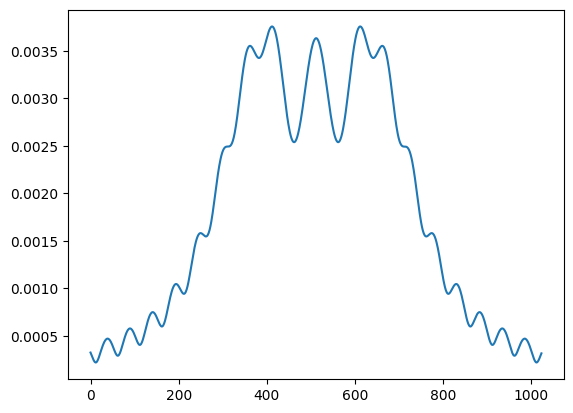

In [166]:
g_z = numerical_integration()
plt.plot(g_z)
plt.show()

In [167]:
# numerical_list= np.zeros(10)
# AS_list =np.zeros(10)

# for  wave_length in range(50,60):
#     AS_spectrum, AS_result = AS(wave_length=wave_length, n_S=50, band_limit=-1)
#     numerical_result = numerical_integration(wave_length=wave_length, n_S=50)

#     numerical_list[wave_length-50] = AS_result[int(1024/2-1)]+AS_result[int(1024/2)]
#     AS_list[wave_length-50] = numerical_result[int(1024/2-1)]+numerical_result[int(1024/2)]

In [168]:
# attenuation_coefficient = AS_list/numerical_list
# diff = np.diff(attenuation_coefficient)
# plt.plot(attenuation_coefficient)
# plt.show()

# print(diff)


In [169]:
# def RMS(array1,array2):    
#     # rms1 = np.sqrt(np.mean(array1**2))
#     # rms2 = np.sqrt(np.mean(array2**2))
#     rms1 = np.std(array1)
#     rms2 = np.std(array2)
#     return rms1/rms2

In [170]:
# def RMS(array1,array2):    
#     # rms1 = np.sqrt(np.mean(array1**2))
#     # rms2 = np.sqrt(np.mean(array2**2))
#     rms1 = array1[512-1]+array1[512]
#     rms2 = array2[512-1]+array2[512]
#     return rms1/rms2

In [171]:
# def RMS(array1,array2):    
#     # rms1 = np.sqrt(np.mean(array1**2))
#     # rms2 = np.sqrt(np.mean(array2**2))
#     rms1 = np.mean(array1)
#     rms2 = np.mean(array2)
#     return rms1/rms2

In [172]:
def RMS(array1,array2):    
    rms1 = np.sqrt(np.mean(np.square(array1)))
    rms2 = np.sqrt(np.mean(np.square(array2)))
    return rms1/rms2

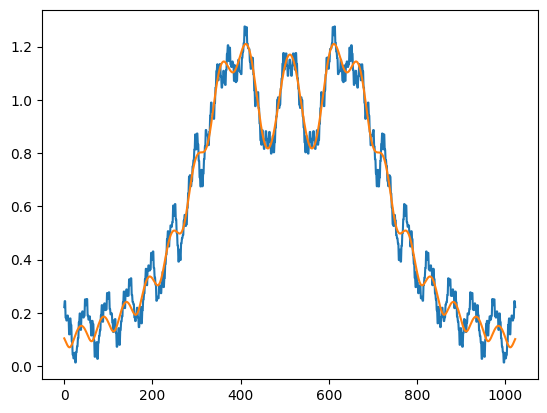

In [173]:
AS_spectrum, AS_result = AS(1, 50, -1)
numerical_result = numerical_integration(1, 50)
reference_field = RMS(AS_result, numerical_result) * numerical_result
plt.plot(AS_result)
plt.plot(reference_field)
plt.show()

In [174]:
def SNR_cal(signal, noisy_signal):
    signal_power = np.mean(np.square(signal))
    noise_power = np.mean(np.square(noisy_signal - signal))
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [175]:
SNR = []

n_S_list = list(np.linspace(-1, 2, 100))

for n_S in n_S_list:
    n_S = 10**n_S
    AS_spectrum, AS_result = AS(10000, n_S, -1)
    numerical_result = numerical_integration(10000, n_S)
    numerical_result_normalized = numerical_result * RMS(AS_result, numerical_result)
    SNR.append(SNR_cal(numerical_result_normalized,AS_result))

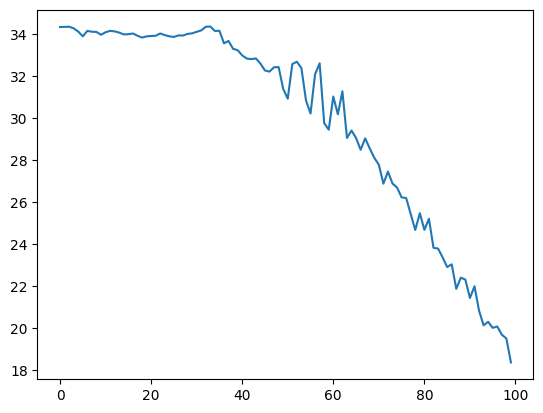

In [176]:
plt.plot(SNR)
# plt.xscale('log')
# plt.xticks([0.1, 1, 10, 100])
plt.show()

In [ ]:
SNR_1 = SNR
